#Model Evaluation & Deployment
##Table of Contents
* I. Introduction
* II. Dataset Split
* III. Build Model Pipelines
* IV. Declare Hyperparameter Grids
* V. Fit and Tune Models
* VI. Pick a Winning Model
* VII. Model Test & Delivery

##I. Introduction

Finally, we will evaluate the winning model and create an executable model script that the HR company can run as they gather new data.

In [44]:
# Import libraries
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('darkgrid')

# Pickle for saving model files
import pickle

# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# StandardScaler
from sklearn.preprocessing import StandardScaler

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# Classification metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

from __future__ import print_function
import sys

In [2]:
# Load ABT
abt = pd.read_csv('analytical_base_table.csv')

##II. Dataset Split

First we want to split our dataset into training and test sets. Because our data is limited, we'll set aside 20% of our data for testing and perform cross validation to get the most out of our training set.

In [3]:
# Create separate object for target variable
y = abt.status

# Create separate object for input features
X = abt.drop('status', axis=1)

In [4]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1234,
                                                    stratify=abt.status)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

11254 2814 11254 2814


##III. Build Model Pipelines

Next we'll set up preprocessing pipelines for each of our algorithms. But first we'll standardize our features to bring them all to the same scale.

We'll create a single pipeline dictionary with pipelines for each algorithm:

* 'l1' for L1-regularized logistic regression

* 'l2' for L2-regularized logistic regression

* 'rf' for random forest

* 'gb' for gradient boosted tree

In [5]:
# Pipeline dictionary
pipelines = {
    'l1' : make_pipeline(StandardScaler(),
                        # 'liblinear' solver has to be specified for L1 penalty 
                         LogisticRegression(penalty='l1' , random_state=123, solver='liblinear')),
    'l2' : make_pipeline(StandardScaler(), 
                         LogisticRegression(penalty='l2' , random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}

##IV. Declare Hyperparameter Grids

Let's first list the tunable hyperparameters of our L1-regularized logistic regression pipeline.

All of the keys that begin with ```logisticregression__``` are hyperparameters. We don't need to tune all of them, for regularized logistic regression the most impactful hyperparameter is the strength of the penalty (```logisticregression__C```).

In [6]:
pipelines['l1'].get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression',
   LogisticRegression(penalty='l1', random_state=123, solver='liblinear'))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(penalty='l1', random_state=123, solver='liblinear'),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l1',
 'logisticregression__random_state': 123,
 'logisticregression__solver': 'liblinear',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_

In [7]:
# Logistic Regression hyperparameters
l1_hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
}

l2_hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
}

Let's do the same thing for our random forest and boosted tree models:

In [8]:
# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5, 10]
}

In [9]:
# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

Let's store all the hyperparameters in a dictionary for ease of use:

In [10]:
# Create hyperparameters dictionary
hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

##V. Fit and Tune Models

We can tune our models with cross-validation using GridSearchCV and create a fitted_models dictionary containing all the models.

In [11]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    # Set n_jobs=-1 to use as many cores as available on your computer
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

l1 has been fitted.
l2 has been fitted.
rf has been fitted.
gb has been fitted.


##VI. Pick a Winning Model

Now let's see which model performs the best. The ```best_score_``` feature will give us the holdout accuracy, i.e. the percent of observations correctly classified by the model.

In [12]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print(name, model.best_score_)

l1 0.8606721926189067
l2 0.8605833826721927
rf 0.9796513913558318
gb 0.9755640813104401


However, this is not always the best way to evaluate a classification model. Instead, a confusion matrix is a better option.

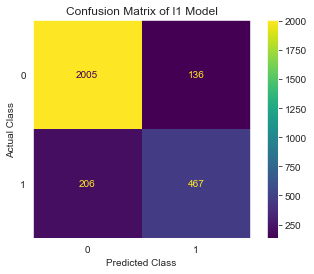

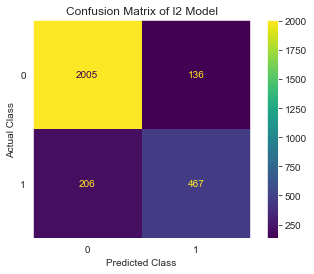

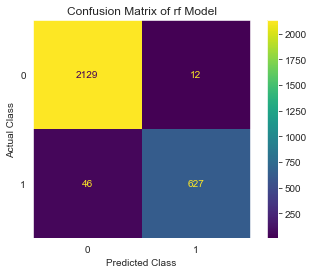

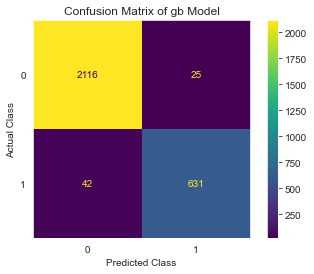

In [34]:
for name, model in fitted_models.items():
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=model.classes_)
    disp.plot()
    disp.ax_.set(
                title=f'Confusion Matrix of {name} Model', 
                xlabel='Predicted Class', 
                ylabel='Actual Class')
    plt.grid(False)
    plt.show()

We can also plot the entire ROC curve for each model if we wanted. Here is the ROC curve for the Random Forest model:

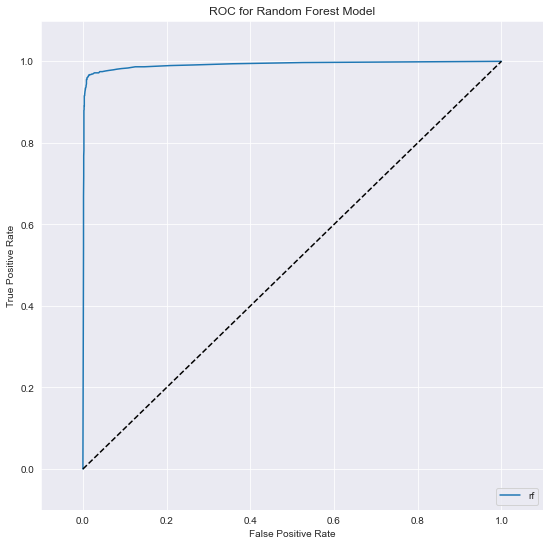

In [36]:
# Predict probabilities using L1-regularized logistic regression
pred = fitted_models['rf'].predict_proba(X_test)

# Get just the prediction for the positive class (1)
pred = [p[1] for p in pred]

# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)

# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('ROC for Random Forest Model')

# Plot ROC curve
plt.plot(fpr, tpr, label='rf')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [15]:
# AUROC performance of each model
for name, model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    print( name, roc_auc_score(y_test, pred) )

l1 0.9167481554841337
l2 0.9167599537231425
rf 0.9919029379697174
gb 0.9893975472155115


The random forest model has the highest test AUROC score (0.99). Let's save the winning pipeline object into a pickle file.

In [16]:
with open('final_model_rf.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)

##VII. Model Test & Delivery 
Now we want to test our model on unseen data and see how it performs. This will be similar to when the company feeds new data to the model as they continue to collect more employee information over time. 

First, we need to get the data into the same format as our ABT. To streamline the process for users, we can create the class ```EmployeeRetentionModel``` that bundles together the data cleaning and feature engineering steps. This will ensure that any new data undergoes the same processing steps as our ABT.

The ```main``` function will run the random forest model with new data, output the predictions to a csv, and handle the data cleaning and feature engineering steps.

In [54]:
new_data = pd.read_csv('unseen_employee_data.csv')

In [52]:
class EmployeeRetentionModel:
    
    def __init__(self, model_location):
        with open(model_location, 'rb') as f:
            self.model = pickle.load(f)
    
    def predict_proba(self, X_new, clean=True, augment=True):
        if clean:
            X_new = self.clean_data(X_new)
        
        if augment:
            X_new = self.engineer_features(X_new)
            
        return X_new, self.model.predict_proba(X_new)
    
    # Add functions here
    def clean_data(self, df):
        # Drop duplicates
        df = df.drop_duplicates()

        # Drop temporary workers
        df = df[df.department != 'temp']

        # Missing filed_complaint values should be 0
        df['filed_complaint'] = df.filed_complaint.fillna(0)

        # Missing recently_promoted values should be 0
        df['recently_promoted'] = df.recently_promoted.fillna(0)

        # 'information_technology' should be 'IT'
        df.department.replace('information_technology', 'IT', inplace=True)

        # Fill missing values in department with 'Missing'
        df['department'].fillna('Missing', inplace=True)

        # Indicator variable for missing last_evaluation
        df['last_evaluation_missing'] = df.last_evaluation.isnull().astype(int)

        # Fill missing values in last_evaluation with 0
        df.last_evaluation.fillna(0, inplace=True)

        # Return cleaned dataframe
        return df
    
    def engineer_features(self, df):
        # Create indicator features
        df['underperformer'] = ((df.last_evaluation > 0.4) & (df.last_evaluation < 0.65) & (df.satisfaction > 0.3) & (df.satisfaction < 0.55)).astype(int)

        df['unhappy'] = ((df.last_evaluation > 0.7) & (df.last_evaluation_missing == 0) & (df.satisfaction < 0.2)).astype(int)

        df['overachiever'] = ((df.last_evaluation > 0.8) & (df.satisfaction > 0.7)).astype(int)

        # Create new dataframe with dummy features
        df = pd.get_dummies(df, columns=['department', 'salary'])

        # Return augmented DataFrame
        return df


def main(data_location, output_location, model_location, clean=True, augment=True):
    # Read dataset
    df = pd.read_csv(data_location)

    # Initialize model
    retention_model = EmployeeRetentionModel(model_location)

    # Make prediction
    df, pred = retention_model.predict_proba(df)
    pred = [p[1] for p in pred]

    # Add prediction to dataset
    df['prediction'] = pred

    # Save dataset after making predictions
    df.to_csv(output_location, index=None)

In [53]:
# Run the model on new data
main('unseen_employee_data.csv', 'predictions.csv','final_model_rf.pkl', True, True)

In [55]:
# View the predictions
predictions = pd.read_csv('predictions.csv')

predictions.head()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,last_evaluation_missing,underperformer,unhappy,overachiever,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium,prediction
0,228,0.0,0.735618,2,0.0,0.805661,3.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.00
1,229,0.0,1.000000,4,0.0,0.719961,4.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.10
2,196,1.0,0.557426,4,0.0,0.749835,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.04
3,207,0.0,0.715171,3,0.0,0.987447,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.00
4,129,0.0,0.484818,2,0.0,0.441219,3.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.27
